In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# setting global font size for charts to be 12
plt.rcParams['font.size'] = 12

In [3]:
movies = pd.read_csv('./datasets/movies.csv')
ratings = pd.read_csv('./datasets/ratings.csv')
tags = pd.read_csv('./datasets/tags.csv')
links = pd.read_csv('./datasets/links.csv')

The metrics that I would like to use will be RMSE or Precision@k. I will be focused on increasing the precision score and decreasing the RMSE in order to provide the most relevant movie recommendation to the user.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


The links file is useful if we want to find a way to link the information here back to the `imdb` or `tmdb` database. Since we are focusing on building a recommender system, we will only be using the `movies`, `ratings` and the `tags` file.

From the information on the webpage where the dataset was obtained, we can expect the dataset to require minimal or no cleaning. Let us perform a few checks on the dataset to ensure that this is indeed the case.

In [8]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [10]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [12]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,3.261276e+02,1.826185e+02,1.0,1.770000e+02,3.250000e+02,4.770000e+02,6.100000e+02
movieId,100836.0,1.943530e+04,3.553099e+04,1.0,1.199000e+03,2.991000e+03,8.122000e+03,1.936090e+05
rating,100836.0,3.501557e+00,1.042529e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,100836.0,1.205946e+09,2.162610e+08,828124615.0,1.019124e+09,1.186087e+09,1.435994e+09,1.537799e+09


The most relevant field here would be the `rating` row. Let's zoom into that row.

In [13]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

It is interesting to see that the mean rating given to movies is 3.5, and additionally if we look at the different percentiles, we can clearly see that there is a skew towards higher scores as the 25th percentile is already at a `rating` of **3**, and the rest of the percentiles are a little more evenly spread out. 

This shows that there most likely is a bias among the users who do give ratings. They tend to give higher scores, which means that we need to treat scores of 3.5 and below as a below average movie, and only movies with 3.5 and above as above average movies. This is an interesting insight into our data.

We will further explore why this might be during the EDA portion of this notebook.

In [14]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [15]:
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [16]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Since we have verified that there are no null values in our dataset, and all object types in our data seem to be correct. We will proceed with some cleaning of a few of the columns, and then we will proceed with exploratory data analysis.

First let's replace the '|' in our `genre` columns so that we can use it in our EDA and modeling.

In [17]:
movies['genres'] = movies['genres'].map(lambda x: x.replace('|', ' '))

With this done, let's move on to exploratory data analyis.

---

# Exploratory Data Analysis

Before we begin, let's merge all our datasets into 1 dataset. This will allow us to call just one file to access all of the data instead of three separate files.

In [18]:
# to make matters easy, we will refer to our 
# merged dataset as df.

df = pd.merge(ratings, movies, 
              how='inner', 
              on='movieId'
             )

In [19]:
df_merged_tags = pd.merge(df,tags.drop(columns=['timestamp']),
                how='left', 
                on=['userId', 'movieId']
               )

Let's check to make sure the merge is done successfully.

In [20]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy


In [21]:
df_merged_tags.head()

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN


The dataframe with merged tags looks a little messy, due to the nulls that were generated in the process of joining the tags. To resolve this, let's create a custom function that we will use on the dataframe with the `apply` method.

In [22]:
def genres_tags(row):
    """This function is meant to be used with the 
    'apply' method. Accepts input of a row, and outputs
    a new column 'genres+tag', which combines the 2 
    individual columns. The function ignores an null 
    values in the 'tag' column."""
    
    if str(row['tag']) == 'nan':
        row['genres+tag'] = row['genres']
    else:
        row['genres+tag'] = row['genres'] + '|' + row['tag']
    return row

In [23]:
# creates the new column 'genres+tag'
df_merged_tags = df_merged_tags.apply(genres_tags, axis=1)

# drops the original columns as it is not needed anymore
df_merged_tags.drop(columns=['genres', 'tag'], inplace=True)

# drops any duplicates that may have been accidentally created
df_merged_tags.drop_duplicates(keep='first', inplace=True)

Now that we have created two merged dataframes, let's proceed with the EDA. 

To evaluate whether there is merit to use the dataframe with combined tags, we will see if it makes a difference to the types of words associated with the movies.

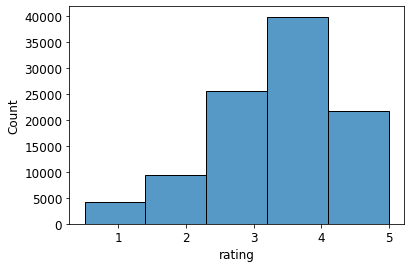

In [24]:
sns.histplot(data=df, x='rating', bins=5);

The above distribution confirms what we found using the `describe` method. Our users have rated the movies with a bias. We might expect the ratings to be normally distributed around the center, i.e. `2.5`, however we know that the mean is instead, 3.5. There are a few possible reasons for this:
1. Most likely, the users are subject to some sort of combination between [Central Tendency Bias and Leniency Bias](https://www.trakstar.com/blog-post/8-rater-biases-impacting-performance-management/). This could have led to a higer average rating.
2. It could be that the pool of movies that we have available, have performed better than average, and they are of higher than average quality overall, which explains the average rating of 3.5.

Let's take a look at the distribution of how often the movies were viewed.

In [25]:
# get series of value counts for each movie
sr_movie_valuecounts = df['title'].value_counts().sort_values(ascending=False)

# create dataframe for plotting purposes
df_movie_valuecounts = pd.DataFrame(columns=['title', 'count'])

# add the series values into the dataframe
df_movie_valuecounts['title'] = sr_movie_valuecounts.index
df_movie_valuecounts['count'] = sr_movie_valuecounts.values

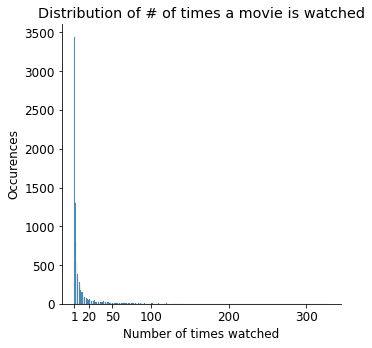

In [26]:
# plotting the distribution of the number of times each movie was watched
sns.displot(data=df_movie_valuecounts, x='count')
plt.xticks([1, 20, 50, 100, 200, 300])
plt.ylabel('Occurences')
plt.xlabel('Number of times watched')
plt.title('Distribution of # of times a movie is watched')
plt.tight_layout();

The `x-axis` above represents the number of times a movie was watched, and the `y-axis` represents the number of times this 'movie count' occured. 

For example, let's take the first datapoint on the `x-axis`, **1**, there were close to 3500 movies that were watched only 1 time. This drops drastically even as we go to movies that might have been watched 10 times. This is to be expected as there would be only few movies that would be mega popular across these users.

## See if this should be added in here or not: perhaps the recommender system can help with recommending those movies that are less popular more often. 

Now let's take a look at the genres that were most popular. We will do this on two levels.
1. Across the unique movies
2. Across the movies that have actually been watched by users. 

We will also take a look at the same across tags, and movie titles. We will look at this on both charts and in a wordcloud as well.

In [27]:
# Create function to get top words
def plot_top_words(df, col, n, n_gram_range, title, palette='tab10'):
    """accepts dataframe, column name in text, number of words, 
    ngrams, title of chart and the color palette for chart"""
    
    def get_top_n_words(corpus, n=n, k=n_gram_range):
        """internal function that retruns top n words"""
        
        # countvectorizer to vectorize words in column
        vec = CountVectorizer(ngram_range=(k,k), stop_words='english').fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    
    # create a DataFrame of top words
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','freq'])
    
    # plot the figure
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)

In [28]:
def plot_wordcloud(df, col, color):
    """The Function outputs a wordcloud based 
    on the kwargs passed in.
    Accepts a dataframe, a column in the dataframe 
    and the background color to be used for the wordcloud."""
    corpus = ' '.join(df[col])
    corpus_wordcoloud = WordCloud(background_color=color,
                                  collocations=False,
                                  height=2000, 
                                  width=4000).generate(str(corpus))
    # Plot the wordcloud
    plt.figure(figsize=(15,15))
    plt.imshow(corpus_wordcoloud)
    plt.axis('off');

#### Unique Movie Genres

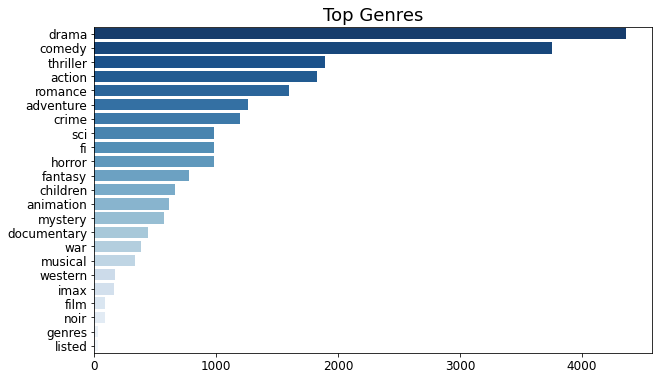

In [29]:
plot_top_words(movies, 'genres', 30, 1, 'Top Genres', 'Blues_r')

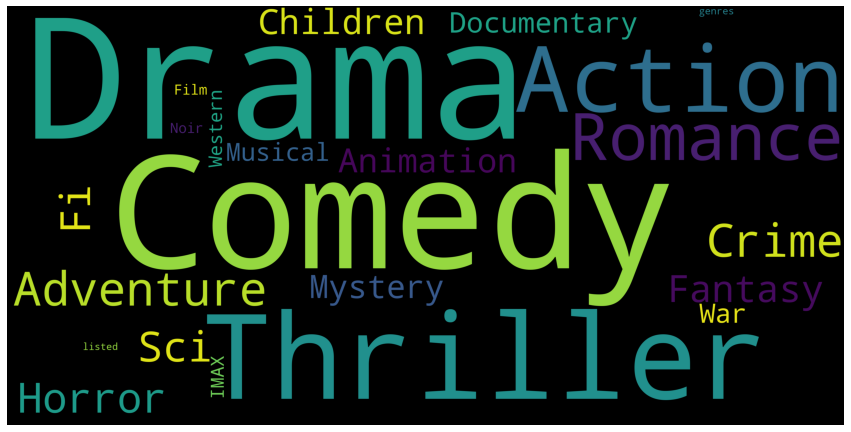

In [30]:
plot_wordcloud(movies, 'genres', 'Black')

#### Movie Genres across all users

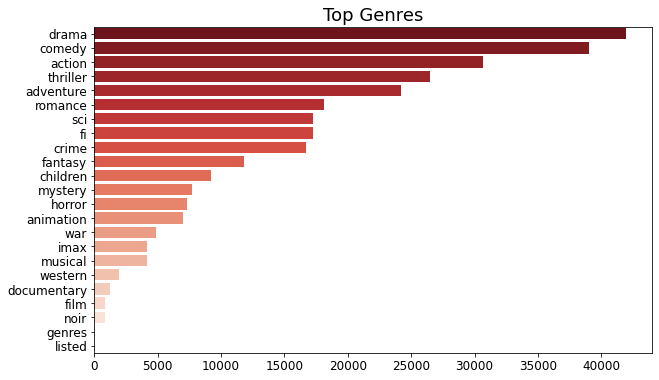

In [31]:
plot_top_words(df, 'genres', 30, 1, 'Top Genres', 'Reds_r')

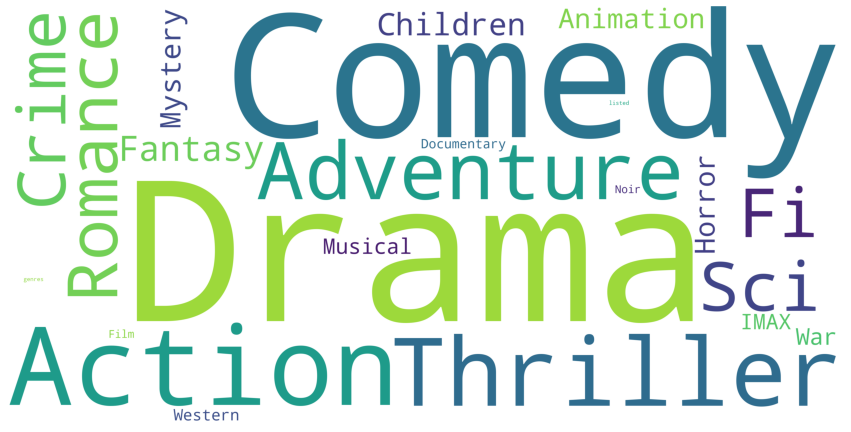

In [32]:
plot_wordcloud(df, 'genres', 'White')

---

#### Unique Move Titles

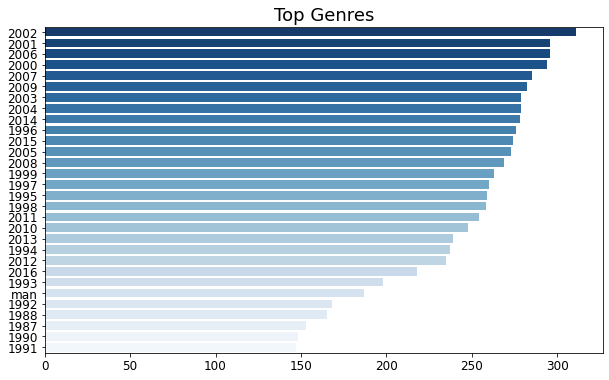

In [33]:
plot_top_words(movies, 'title', 30, 1, 'Top Genres', 'Blues_r')

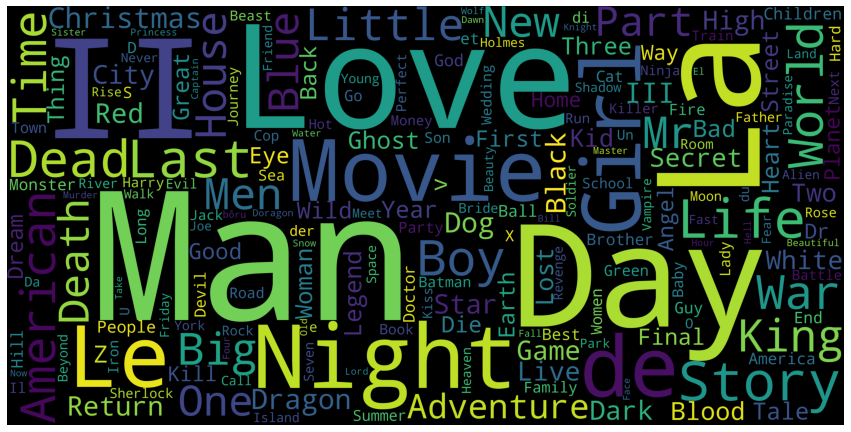

In [34]:
plot_wordcloud(movies, 'title', 'Black')

#### Movie Titles across all users

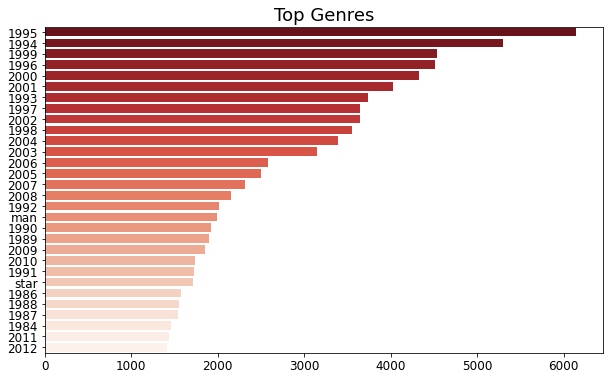

In [35]:
plot_top_words(df, 'title', 30, 1, 'Top Genres', 'Reds_r')

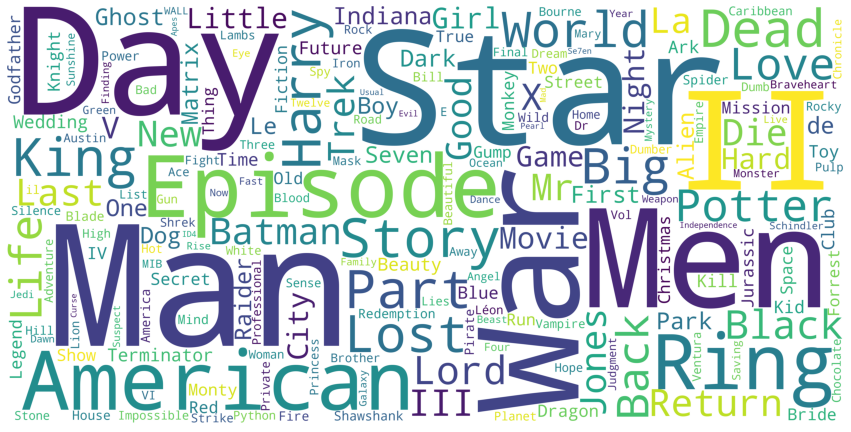

In [36]:
plot_wordcloud(df, 'title', 'White')

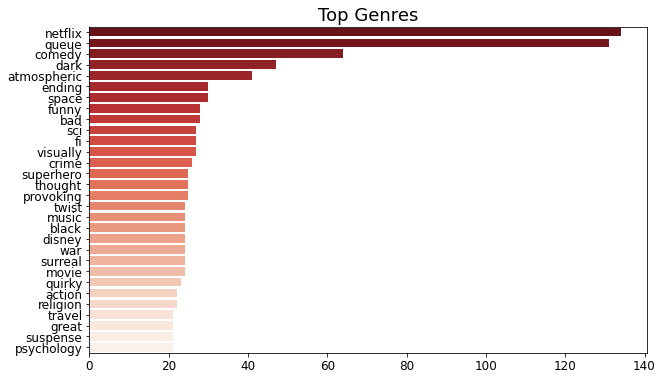

In [43]:
plot_top_words(tags, 'tag', 30, 1, 'Top Genres', 'Reds_r')

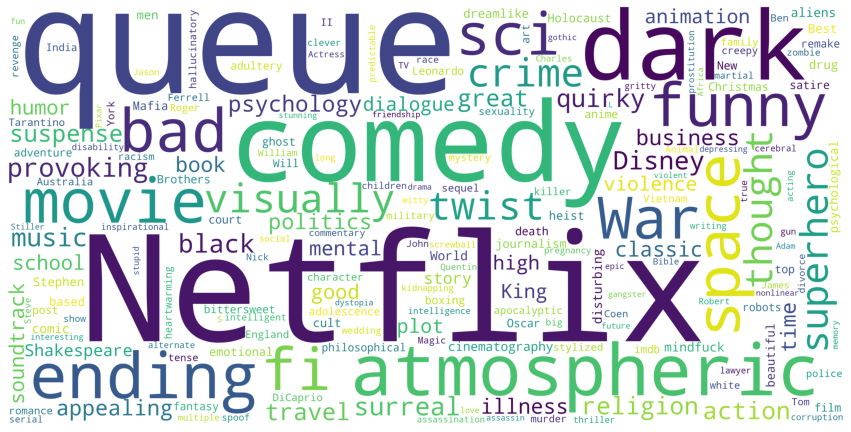

In [44]:
plot_wordcloud(tags, 'tag', 'White')

In [47]:
df.to_csv('./datasets/merged_users+movies.csv', index=False)
df_merged_tags.to_csv('./datasets/merged_users+movies+tags.csv', index=False)

In [49]:
movies.to_csv('./datasets/movies.csv', index=False)

# More EDA
1. Average ratings for movies
    compare the above with the movies that have been watched most often
    i.e. popularity vs rating
2. 

# To Do:
1. Fix the issue with the top unigram chart where it's showing the year instead of the words.
2. Finish off EDA
3. Create the first model, set up the method to actually obtain the RMSE and the precision @k etc. I believe that will be the most complicated part of the project.
4. Error analysis of the first model.

In [37]:
# groupby movie, get mean rating, and then do a countvec on this list. Drop user for this.

In [38]:
df['title'].value_counts().sort_values(ascending=False).tail(20)

Heartbreaker (L'Arnacoeur) (2010)                          1
Mood Indigo (L'écume des jours) (2013)                     1
The Devil's Candy (2015)                                   1
Wadjda (2012)                                              1
Zazie dans le métro (1960)                                 1
Make Way for Tomorrow (1937)                               1
Boudu Saved From Drowning (Boudu sauvé des eaux) (1932)    1
Only Yesterday (Omohide poro poro) (1991)                  1
Chouchou (2003)                                            1
Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)    1
Meshes of the Afternoon (1943)                             1
Cat Soup (Nekojiru-so) (2001)                              1
Polytechnique (2009)                                       1
Still Walking (Aruitemo aruitemo) (2008)                   1
I Shot Jesse James (1949)                                  1
Trash Humpers (2009)                                       1
Red Tails (2012)        

# add in that most likely, to let the ratings make sense, we need to view the history of each user, then we need to make changes to the ratings. So for the specific user, what is the mean? if the mean is 3.5, bring it down to 2.5. And replicate this for all. If this isn't done, it will result in mismatch of recommendations. Because if 1 user likes something 5, that could be a 4 for another user. So we have to look at the distributions for each user, and "normalize" (wrong word) it so that across the board, a 2.5 refers to an average movie. I will try this during the error evaluation portion.

---

# EDA can continue down below. Finish up the preliminary analysis.